In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns;sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import time
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/new_merged.csv')

In [4]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

In [5]:
df = df.set_index('TIMESTAMP')

In [6]:
df['log_return'] = np.log(df['CLOSE']/df['CLOSE'].shift(1))

In [7]:
## Features Related to Returns, AMOUNT and Volatility up to past 120 ticks
for i in range(5, 125, 5):
    df['log_return_'+str(i)] = df['log_return'].rolling(window=i).sum()

df['liquidity_log_return'] = np.log(df['LIQUIDITYPRICE_pepe']/df['LIQUIDITYPRICE_pepe'].shift(1))
for i in range(5, 125, 5):
    df['liquidity_log_return_'+str(i)] = df['liquidity_log_return'].rolling(window=i).sum()

for i in range(5, 125, 5):
    df['AMOUNT_pepe_'+str(i)] = df['AMOUNT_pepe'].rolling(window=i).mean()

for i in range(5, 125, 5):
    df['AMOUNT_weth_'+str(i)] = df['AMOUNT_weth'].rolling(window=i).mean()

df = df.copy()
for i in range(5, 125, 5):
    df['vol_'+str(i)] = df['log_return'].rolling(window=i).std()*np.sqrt(i)

In [8]:
df['return_label'] = df['log_return'].shift(-1)
df['label'] = np.where(df['return_label']>0, 1, 0)

In [9]:
df = df.drop(columns = ['OPEN','CLOSE', 'HIGH', 'LOW', 'VOLUME','LIQUIDITYPRICE_pepe', 'AMOUNT_pepe', 'AMOUNT_weth', 'return_label'])

In [10]:
df = df.copy()
df = df.dropna()

In [11]:
!pip install -U kaleido

In [12]:
!pip install shap

In [13]:
!pip install catboost

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBClassifier,XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

In [15]:
models = []
# Lightweight Models
models.append(('LDA', LinearDiscriminantAnalysis()))  # Unsupervised Model
models.append(('KNN', KNeighborsClassifier()))  # Unsupervised Model
models.append(('TREE', DecisionTreeClassifier())) # Supervised Model
models.append(('NB', GaussianNB())) # Unsupervised Model

# More Advanced Models
models.append(('GBM', GradientBoostingClassifier(n_estimators=25)))
models.append(('XGB',XGBClassifier(n_estimators=25,eval_metric='logloss')))
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=25)))
models.append(('RF', RandomForestClassifier(n_estimators=25)))

In [16]:
def modelEval(ldf,feature='label',split_id=[None,None],eval_id=[True,True,True,True],
              n_fold=5,scoring='accuracy',plot_id=[False,True],cv_yrange=None,hm_vvals=[0.5,1.0,0.75]):

    print('Evaluation Function')
    print(f'Cross Validation Activated, n_splits : {n_fold}, scoring metric: {scoring}')
    if(eval_id[2]):
        if(split_id[0] is not None):
            print(f'Train/Evaluation Set Spit Activated: {split_id[0]}')
        if(split_id[1] is not None):
            print(f'Train/Evaluation Set Split made at {split_id[1]}')

    ''' 1. Split Train/Evaluation <DataFrame> Set Split '''

    # split_id : Train/Test split [%,timestamp], whichever is not None
    # test_id : Evaluate trained model on test set only

    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,eval_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split
        train_df = df.loc[:split_id[1]]; eval_df = df.loc[split_id[1]:]
    else:
        print('Choose One Splitting Method Only')

    ''' 2. Train/Test Feature Matrices + Target Variables Split'''

    y_train = train_df[feature]
    X_train = train_df.loc[:, train_df.columns != feature]
    y_eval = eval_df[feature]
    X_eval = eval_df.loc[:, eval_df.columns != feature]
    X_one = pd.concat([X_train,X_eval],axis=0)
    y_one = pd.concat([y_train,y_eval],axis=0)

    print('');print(f'Using Features: {X_train.columns}')
    print(f'Target Variable: {feature}');print('')

    ''' 3. Visualise Training/Test Data'''
    if(plot_id[0]):

        # plot the training data
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=train_df.index, y=train_df['signal'],mode='lines',name='Training Data', line={'width': 0.25}))
        fig.update_layout(height=300,width=800,template='plotly_white',title='Training Signal Visualisation',
                          margin=dict(l=50,r=80,t=50,b=40))

        # Plot the test data as well
        if(eval_id[2]):
            fig.add_trace(go.Scatter(x=eval_df.index, y=eval_df['signal'],mode='lines',name='Test Data',line={'width': 0.25}))
            fig.update_layout(title='Training/Test Signal Visualisation')
        fig.show()

    ''' 4. Cross Validation, Training/Evaluation, one evaluation'''
    lst_res = []; names = []; lst_train = []; lst_eval = []; lst_one = []; lst_res_mean = []
    if(any(eval_id)):
        for name, model in models:  # cycle through models & evaluate either cv or train/test
            names.append(name)

            # Cross Validation Model on Training Se
            if(eval_id[0]):
                t0=time.time()
                kfold = KFold(n_splits=n_fold)
                cv_res = cross_val_score(model,X_train,y_train, cv=kfold, scoring=scoring)
                t1 = time.time()
                lst_res.append(cv_res)
                tt1 = t1-t0 # total time for n_fold cross evaluation

            # Evaluate Fit Model on Training Data
            t2 = time.time()
            if(eval_id[1]):
                t2 = time.time()
                res = model.fit(X_train,y_train)
                train_res = accuracy_score(res.predict(X_train),y_train); lst_train.append(train_res)
            if(eval_id[2]):
                if(eval_id[1] is False):  # If training hasn't been called yet
                    res = model.fit(X_train,y_train)
                eval_res = accuracy_score(res.predict(X_eval),y_eval); lst_eval.append(eval_res)
            t3 = time.time()
            tt2 = t3-t2 # total time for training/evaluation train/prediction

            # Evaluate model on entire dataset
            if(eval_id[3]):
                t4 = time.time()
                res = model.fit(X_one,y_one)
                one_res = accuracy_score(res.predict(X_one),y_one); lst_one.append(one_res)
                t5 = time.time()
                tt3 = t5-t4 # total time for training & evaluation on whole dataframe

            ''' [out] Verbal Outputs '''
            # Cross Validation / Training / Evaluation Model Evaluation / Section Times
            lst_res_mean.append(cv_res.mean())
            fn1 = cv_res.mean(); fn2 = cv_res.std();
            fn3 = train_res; fn4 = eval_res; fn5 = one_res
            print(f"{name} : {fn1:.3f}({fn2:.3f}) -> {tt1:.2f}s | {fn3:.3f} & {fn4:.3f} -> {tt2:.2f}s | {fn5:.3f} -> {tt3:.2}s")

    s0 = pd.Series(np.array(lst_res_mean),index=names)
    s1 = pd.Series(np.array(lst_train),index=names)
    s2 = pd.Series(np.array(lst_eval),index=names)
    s3 = pd.Series(np.array(lst_one),index=names)
    pdf = pd.concat([s0,s1,s2,s3],axis=1)
    pdf.columns = ['cv_average','train','test','all']
    s4 = pd.Series([tt1,tt2,tt3],index=['cv','train/test','all'])

    ''' 5. Visual Ouputs '''
    if(plot_id[1]):

        sns.set(style="whitegrid")
        fig,ax = plt.subplots(1,2,figsize=(15,4))
        ax[0].set_title(f'{n_fold} Cross Validation Results')
        sns.boxplot(data=lst_res, ax=ax[0], orient="v",width=0.3)
        ax[0].set_xticklabels(names)
        sns.stripplot(data=lst_res,ax=ax[0], orient='v',color=".3",linewidth=1)
        ax[0].set_xticklabels(names)
        ax[0].xaxis.grid(True)
        ax[0].set(xlabel="")
        if(cv_yrange is not None):
            ax[0].set_ylim(cv_yrange)
        sns.despine(trim=True, left=True)

        sns.heatmap(pdf,vmin=hm_vvals[0],vmax=hm_vvals[1],center=hm_vvals[2],
                    ax=ax[1],square=False,lw=2,annot=True,fmt='.3f',cmap='Blues')
        ax[1].set_title('Accuracy Scores')
        plt.show()

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.1

Using Features: Index(['log_return', 'log_return_5', 'log_return_10', 'log_return_15',
       'log_return_20', 'log_return_25', 'log_return_30', 'log_return_35',
       'log_return_40', 'log_return_45',
       ...
       'vol_75', 'vol_80', 'vol_85', 'vol_90', 'vol_95', 'vol_100', 'vol_105',
       'vol_110', 'vol_115', 'vol_120'],
      dtype='object', length=122)
Target Variable: label

LDA : 0.570(0.028) -> 2.78s | 0.598 & 0.614 -> 0.54s | 0.600 -> 1.5s
KNN : 0.542(0.036) -> 2.51s | 0.738 & 0.439 -> 4.24s | 0.738 -> 2.4s
TREE : 0.502(0.012) -> 18.58s | 1.000 & 0.479 -> 4.04s | 1.000 -> 7.3s
NB : 0.520(0.089) -> 0.21s | 0.516 & 0.609 -> 0.16s | 0.526 -> 0.068s
GBM : 0.542(0.027) -> 48.12s | 0.629 & 0.581 -> 11.49s | 0.621 -> 1.2e+01s
XGB : 0.525(0.025) -> 6.10s | 0.840 & 0.523 -> 1.12s | 0.801 -> 0.99s
CAT : 0.550(0.035) -> 6.09s | 0.699 & 0.569 -> 1.81s | 

<ipython-input-16-a0a94eb4592b>:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(names)
<ipython-input-16-a0a94eb4592b>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(names)


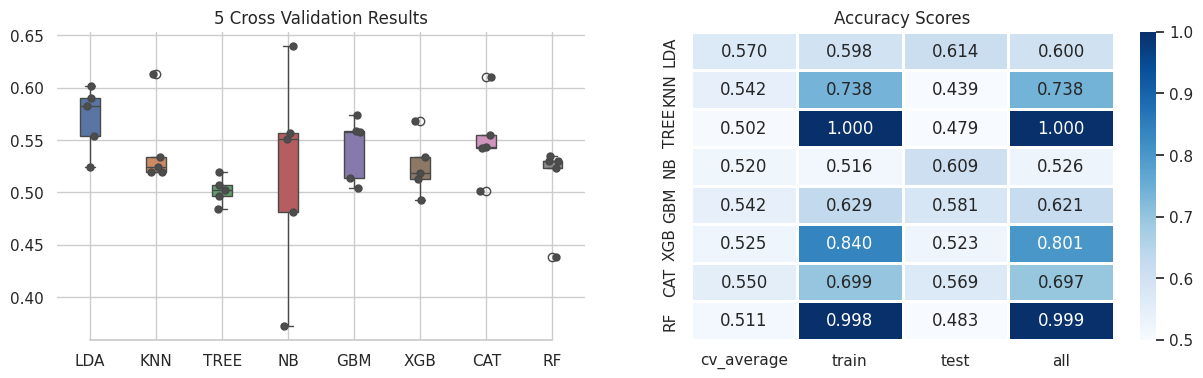

In [17]:
modelEval(df,split_id=[0.1,None],plot_id=[False,True])

In [18]:
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBRegressor
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import shap
import seaborn as sns

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='signal',figsize=(9,0.5),ret_id=False):

    corr_mat = df.corr().round(2)
    shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()

    if(ret_id):
        return corr

''' Feature Importance '''
# Various Approaches for quick FI evaluation

def fi(ldf,target='label',n_est=25,num_only=True,
       drop_id=None,target_cat=True,drop_na=False):

    # Select only numerical features
    if(num_only):
        ldf = ldf.select_dtypes(include=['float64','int64'])

    # Drop all NaN
    if(drop_na):
        print(f'Before NaN drop: {ldf.shape}')
        ldf = ldf.dropna()
        print(f'After NaN dropped: {ldf.shape}')


    ldf = ldf.copy()
    # If target is categorical string variable
    if(target_cat):
        cats = ldf[target].unique()
        cats_id = [i for i in range(0,len(cats))]
        maps = dict(zip(cats,cats_id))
        ldf[target] = ldf[target].map(maps)

    # If any features are desired to be droped
    if(drop_id is not None):
        ldf = ldf.drop(drop_id,axis=1)

    # Input dataframe containing feature & target variable
    y = ldf[target]
    X = ldf.drop(target,axis=1)

#   CORRELATION
    imp = corrMat(ldf,target,figsize=(15,0.5),ret_id=True)
    del imp[target]
    s1 = imp.squeeze(axis=0);s1 = abs(s1)
    s1.name = 'CORR'

#   SHAP
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_sum = np.abs(shap_values).mean(axis=0)
    s2 = pd.Series(shap_sum,index=X.columns,name='CAT_SHAP').T

#   CATBOOST
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['CAT'])
    rf_fi.sort_values('CAT',ascending=False)
    s3 = rf_fi.T.squeeze(axis=0)

#   RANDOMFOREST
    model = RandomForestRegressor(n_est,random_state=0, n_jobs=-1)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['RF'])
    rf_fi.sort_values('RF',ascending=False)
    s4 = rf_fi.T.squeeze(axis=0)

#   XGB
    model=XGBRegressor(n_estimators=n_est,learning_rate=0.5,verbosity = 0)
    model.fit(X,y)
    data = model.feature_importances_
    s5 = pd.Series(data,index=X.columns,name='XGB').T

#   KBEST
    model = SelectKBest(k=5, score_func=f_regression)
    fit = model.fit(X,y)
    data = fit.scores_
    s6 = pd.Series(data,index=X.columns,name='KBEST')

    # Combine Scores
    df0 = pd.concat([s1,s2,s3,s4,s5,s6],axis=1)
    df0.rename(columns={'target':'lin corr'})

    # MinMax Scaler
    x = df0.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled,index=df0.index,columns=df0.columns)
    df = df.rename_axis(f'<b>FI APPROACH</b>', axis=1)
    df = df.rename_axis('Feature', axis=0)

    pd.options.plotting.backend = "plotly"
    fig = df.plot(kind='bar',title='<b>SCALED FEATURE IMPORTANCE</b>',
                  color_discrete_sequence=px.colors.qualitative.T10)
    fig.update_layout(template='plotly_white',height=400,
                     font=dict(family='sans-serif',size=12),
                     margin=dict(l=60, r=40, t=50, b=10))
    fig.update_traces(width=0.25)
    fig.write_image('feature_importance.png', scale=3)
    fig.show()

In [19]:
fi(df)

In [20]:
def scatterPlot(xDF, yDF, algoName):

    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["Component 1","Component 2","Label"]
    g = sns.scatterplot(x="Component 1",y="Component 2",data=tempDF,hue="Label",
                        linewidth=0.5,alpha=0.5,s=15,edgecolor='k')
    plt.title(algoName);plt.legend()

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')

    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)
    ax.grid(axis = 'both',ls='--',alpha = 0.9)
    plt.savefig('Feature_reduction.png', dpi=600)
    plt.show()
def dimRed(ldf,feature='label',split_id=[None,None],n_comp=5,plot_id=True,
           model_id='sparserandomprojection',scaler_id=[False,None]):

    # Given a dataframe, split feature/target variable
    X = ldf.copy()
    y = ldf[feature].copy()
    del X[feature]

    n_jobs = -1; rs = 32

    if(model_id is 'pca'):
        whiten = False
        model = PCA(n_components=n_comp,whiten=whiten,random_state=rs)
    if(model_id is 'sparsepca'):
        alpha = 1
        model = SparsePCA(n_components=n_comp,alpha=alpha,random_state=rs,n_jobs=n_jobs)
    elif(model_id is 'kernelpca'):
        kernel = 'rbf'; gamma = None
        model = KernelPCA(n_components=n_comp,kernel=kernel,gamma=gamma,n_jobs=n_jobs,random_state=rs)
    elif(model_id is 'incrementalpca'):
        batch_size = None
        model = IncrementalPCA(n_components=n_comp,batch_size=batch_size)
    elif(model_id is 'truncatedsvd'):
        algorithm = 'randomized';n_iter = 5
        model = TruncatedSVD(n_components=n_comp,algorithm=algorithm,n_iter=n_iter,random_state=rs)
    elif(model_id is 'gaussianrandomprojection'):
        eps = 0.5
        model = GaussianRandomProjection(n_components=n_comp,eps=eps,random_state=rs)
    elif(model_id is 'sparserandomprojection'):
        density = 'auto'; eps = 0.5; dense_output = True
        model = SparseRandomProjection(n_components=n_comp,density=density,
                                       eps=eps, dense_output=dense_output,random_state=rs)
    if(model_id is 'isomap'):
        n_neigh = 2
        model = Isomap(n_neighbors=n_neigh,n_components=n_comp, n_jobs=n_jobs)
    elif(model_id is 'mds'):
        n_init = 1; max_iter = 50; metric = False
        model = MDS(n_components=n_comp,n_init=n_init,max_iter=max_iter,metric=True,
                    n_jobs=n_jobs, random_state=rs)
    elif(model_id is 'locallylinearembedding'):
        n_neigh = 10; method = 'modified'
        model = LocallyLinearEmbedding(n_neighbors=n_neigh,n_components=n_comp, method=method, \
                                    random_state=rs, n_jobs=n_jobs)
    elif(model_id is 'tsne'):
        learning_rate = 300; perplexity = 30; early_exaggeration = 12; init = 'random'
        model = TSNE(n_components=n_comp, learning_rate=learning_rate, \
                    perplexity=perplexity, early_exaggeration=early_exaggeration, \
                    init=init, random_state=rs)
    elif(model_id is 'minibatchdictionarylearning'):
        alpha = 1; batch_size = 200; n_iter = 25
        model = MiniBatchDictionaryLearning(n_components=n_comp,alpha=alpha,
                                            batch_size=batch_size,n_iter=n_iter,random_state=rs)
    elif(model_id is 'fastica'):
        algorithm = 'parallel'; whiten = 'unit-variance'; max_iter = 100
        model = FastICA(n_components=n_comp, algorithm=algorithm,whiten=whiten,
                          max_iter=max_iter, random_state=rs)

    # Scaling
    if(scaler_id[0]):

        opts = [StandardScaler(),RobustScaler(),MinMaxScaler(), Normalizer(norm='l2')]
        scaler = opts[scaler_id[1]].fit(X)
        X_sca = pd.DataFrame(scaler.fit_transform(X),
                                       columns = X.columns,
                                       index = X.index) # summarize transformed data

    # Unsupervised Dimension Reduction
    if(scaler_id[0]):
        X_red = model.fit_transform(X_sca)
    else:
        X_red = model.fit_transform(X)
    X_red = pd.DataFrame(data=X_red, index=X.index)
    if(plot_id):
        scatterPlot(X_red, y,model_id)
    X_red[feature] = y

    return X_red # return new feature matrix

<>:30: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:33: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:36: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:39: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:42: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:45: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:48: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:52: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:55: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:59: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:63: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:68: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:72: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:30: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:33: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:36: SyntaxWarning:

"is" with a liter

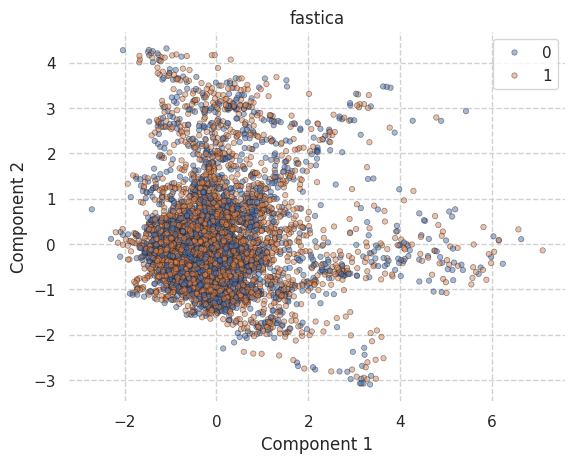

In [21]:
df_new_train = dimRed(df,
                    split_id=[0.1,None],
                    model_id='fastica',
                    n_comp=5,
                    scaler_id=[True,0])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.1

Using Features: Index([0, 1, 2, 3, 4], dtype='object')
Target Variable: label

LDA : 0.583(0.044) -> 0.06s | 0.584 & 0.610 -> 0.01s | 0.587 -> 0.012s
KNN : 0.527(0.016) -> 0.57s | 0.720 & 0.523 -> 0.48s | 0.718 -> 0.44s
TREE : 0.520(0.009) -> 0.45s | 1.000 & 0.521 -> 0.10s | 1.000 -> 0.12s
NB : 0.562(0.035) -> 0.04s | 0.577 & 0.556 -> 0.01s | 0.581 -> 0.0061s
GBM : 0.573(0.033) -> 4.70s | 0.602 & 0.608 -> 0.64s | 0.605 -> 0.71s
XGB : 0.537(0.013) -> 3.36s | 0.731 & 0.587 -> 0.08s | 0.730 -> 0.086s
CAT : 0.563(0.032) -> 0.54s | 0.637 & 0.566 -> 0.10s | 0.637 -> 0.1s
RF : 0.525(0.010) -> 2.98s | 0.998 & 0.586 -> 0.78s | 0.998 -> 0.92s


<ipython-input-16-a0a94eb4592b>:111: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-16-a0a94eb4592b>:113: UserWarning:

FixedFormatter should only be used together with FixedLocator



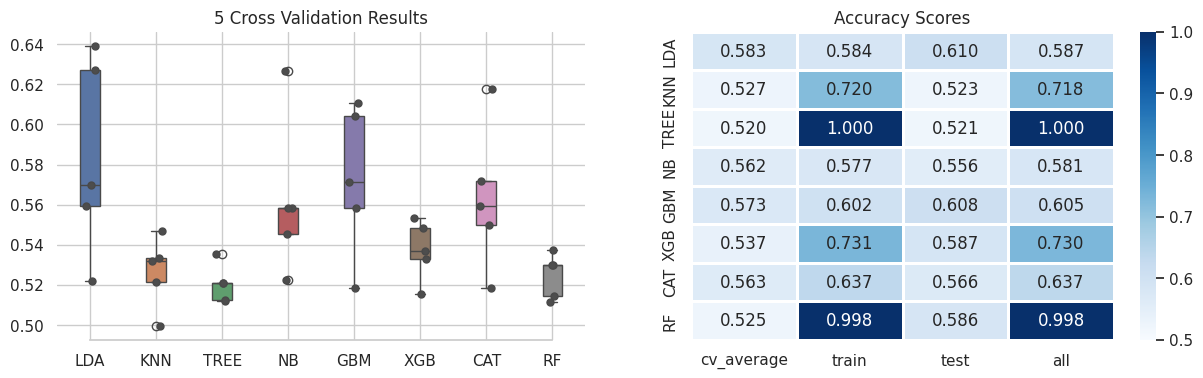

In [22]:
modelEval(df_new_train,
          split_id=[0.1,None],
          plot_id=[False,True])